# Homework IV - NN Model | Zaitsev

## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

## Data

As a remined, we analysed and tried to forecast **CO2 Emissions per Capita in Luxembourg** (source: https://ourworldindata.org/co2/country/luxembourg) and used **Total Manufacturing in Luxembourg** (source: https://fred.stlouisfed.org/series/PRMNTO01LUQ657S) as a helper variable.

In [3]:
data = pd.read_csv("HWIV_data_Zaitsev.csv")

In [4]:
data.head()

,year,co2,ipi
0,1956,1.390418,1.557415
1,1957,1.344955,-0.805235
2,1958,-2.614837,-0.367406
3,1959,0.867290,2.916800
4,1960,3.287197,0.818914


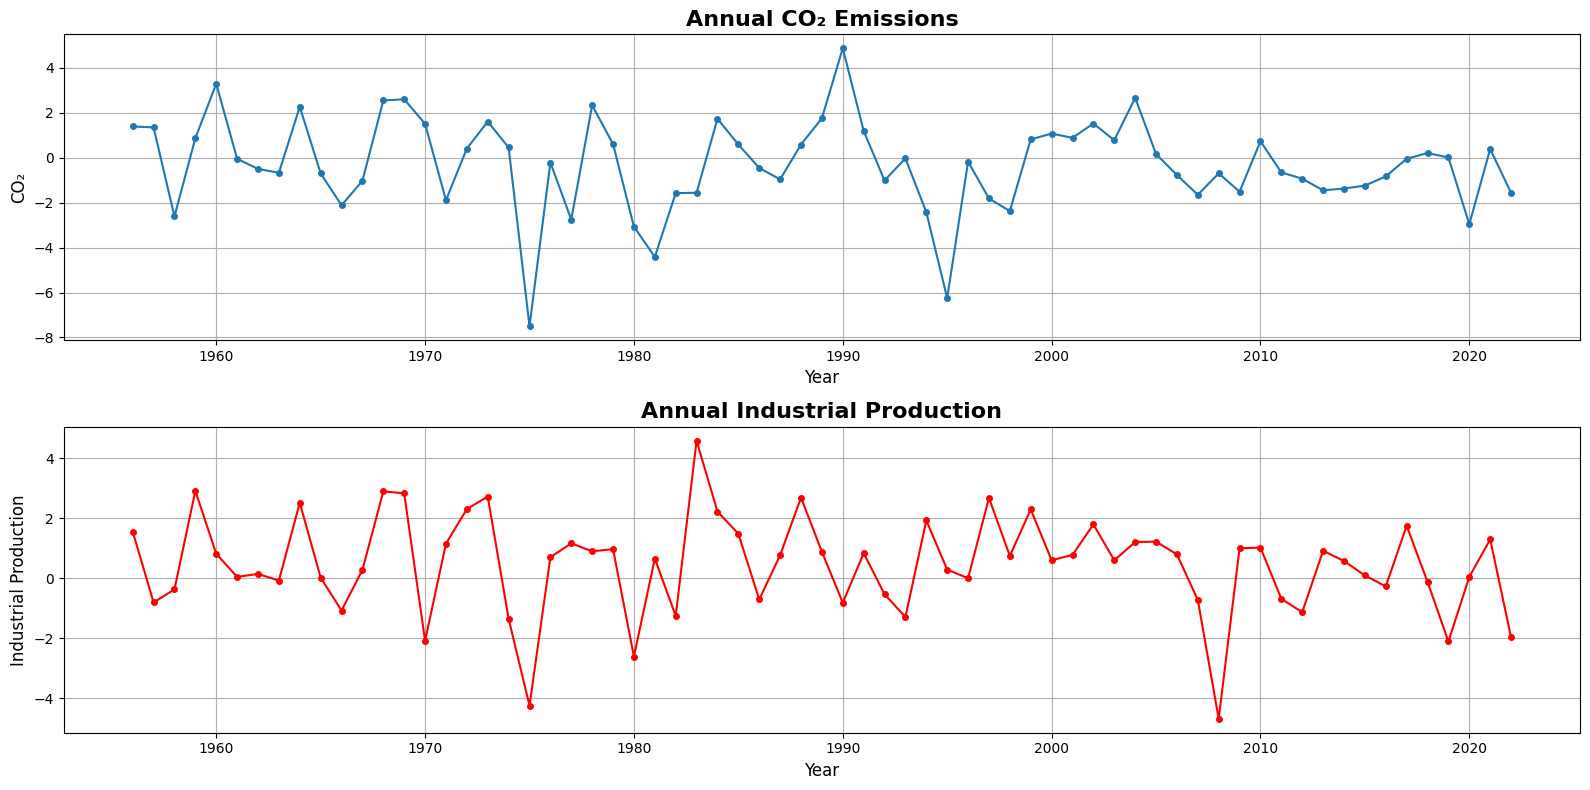

In [5]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

axes[0].plot(data["year"], data["co2"], marker="o", markersize=4, label="CO₂ Emissions")
axes[0].set_title("Annual CO₂ Emissions", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("CO₂", fontsize=12)
axes[0].grid(True)

axes[1].plot(data["year"], data["ipi"], marker="o", markersize=4, label="Industrial Production", color="red")
axes[1].set_title("Annual Industrial Production", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Industrial Production", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Question 1: NN Forecast

### Train/Test Split

First we reserve data for training and forecasting (80% for training).

In [6]:
# select train data
data_ = data[["co2", "ipi"]].reset_index(drop=True)
train_subset_idx = int(len(data_) * 0.8)
num_lags = 8 # hyperparameter, this value was picked after some testing
# split data into train and test
train_data = data_[:train_subset_idx].reset_index(drop=True).to_numpy()
test_data = data_[train_subset_idx - num_lags:].reset_index(drop=True).to_numpy()  # include overlap for sequences


In [7]:
print(f"Train shape: {train_data.shape}; Test shape: {test_data.shape}")

Train shape: (53, 2); Test shape: (22, 2)


### Preprocess Data

Note that we will not split our training data into train/validation sets. This is because we lack data. However, we will use time-series cross-validation techniques to mitigate this issue.

#### Scale (for NN)

In [8]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

#### Prepare Sequences (Lags) for an NN

In [9]:
def createSequences(data, seq_length):
    """
    Prepares sequences (lags) of input data for an NN model.
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # predicting the first variable ("co2")
    return np.array(sequences), np.array(targets)

# create sequences
X_train, y_train = createSequences(train_data_scaled, num_lags)
X_test, y_test = createSequences(test_data_scaled, num_lags)
# convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: torch.Size([45, 8, 2])
y_train: torch.Size([45])
X_test: torch.Size([14, 8, 2])
y_test: torch.Size([14])


### NN Architecture

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate) # lstm layer
        self.fc = nn.Linear(hidden_size, output_size) # fully connected layer
        self.dropout = nn.Dropout(dropout_rate) # dropout. NOTE: dropout=0.2 seems to work the best, e.g. 0.5 is too much
        self.batch_norm = nn.LayerNorm(hidden_size)  # layer normalization

    def forward(self, x):
        h_lstm, _ = self.lstm(x)  # apply lstm layer, output shape: (batch, seq_length, hidden_size)
        h_lstm = self.batch_norm(h_lstm[:, -1, :])  # take last time step's output and apply batch norm
        h_fc = self.dropout(h_lstm) # apply dropout
        return self.fc(h_fc) # apply fc layer

In [11]:
# model parameters
input_size = 2  # number of features
hidden_size = 12 # hyperparameter, this value was picked after some testing
num_layers = 1
output_size = 1
# define model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

### NN Training

#### Loss, Optimizer, Scheduler

In [12]:
class DirectionalMSELoss(nn.Module):
    def __init__(self, mse_alpha=7.0, direction_alpha=0.3):
        """
        Custom loss function combining MSE and direction-based loss.

        Parameters:
            - alpha (float): Weight of the direction loss component.
        """
        super(DirectionalMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.mse_alpha = mse_alpha
        self.direction_alpha = direction_alpha

    def forward(self, predictions, targets):
        # ensure predictions and targets are at least 1D
        if predictions.dim() == 0:
            predictions = predictions.unsqueeze(0)
        if targets.dim() == 0:
            targets = targets.unsqueeze(0)
        # calculate MSE Loss
        mse = self.mse_loss(predictions, targets)
        # skip direction loss if there is only one element in a batch
        if predictions.size(0) < 2:
            return mse  # no direction loss applicable for single element
        # calculate Direction Loss
        pred_directions = torch.sign(predictions[1:] - predictions[:-1])
        true_directions = torch.sign(targets[1:] - targets[:-1])
        direction_loss = torch.mean((pred_directions != true_directions).float())
        # combine MSE and Direction Loss
        total_loss = self.mse_alpha * mse + self.direction_alpha * direction_loss
        return total_loss

In [13]:
criterion = DirectionalMSELoss(mse_alpha=7.0, direction_alpha=0.3)
optimizer = AdamW(model.parameters())
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=8, # number of epochs for the first cycle, hyperparameter, this value was picked after some testing
    T_mult=2, # factor by which the cycle length increases after each restart
    eta_min=1e-6 # minimum learning rate
)

#### Training Loop

In [14]:
def plotTraining(training_losses, validation_losses, learning_rates, fold):
    # create a new figure for each fold
    plt.figure(figsize=(24, 8), num=f"Fold {fold} Training Progress")
    # training loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(training_losses) + 1), training_losses, marker="o", linestyle="-", color="b")
    plt.title(f"Fold {fold} Training Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    # validation loss
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker="o", linestyle="-", color="orange")
    plt.title(f"Fold {fold} Validation Loss Convergence")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    # learning rate
    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker="o", linestyle="-", color="green")
    plt.title(f"Fold {fold} Learning Rate Progression")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.grid(True)
    # display the plot
    plt.tight_layout()
    plt.show()

In [15]:
def trainTSModelCV(model, criterion, optimizer, scheduler, 
                 X, y, 
                 n_folds=3, epochs=200, batch_size=8, patience=20):
    """
    Trains a TimeSeries PyTorch model using TimeSeriesSplit for time-series cross-validation.
    
    Parameters:
        - model (torch.nn.Module): The PyTorch model to train.
        - criterion (torch.nn.Module): Loss function.
        - optimizer (torch.optim.Optimizer): Optimizer for training.
        - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        - X (torch.Tensor): Input data.
        - y (torch.Tensor): Target data.
        - n_folds (int): Number of folds for TimeSeriesSplit.
        - epochs (int): Number of epochs to train.
        - batch_size (int): Batch size for training.
        - patience (int): Number of epochs to wait for improvement before early stopping.
    
    Returns:
        - (dict): A dictionary containing average training and validation losses across folds, 
                  learning rates, and the best model state.
    """
    # define time-series cross-validation folds
    tscv = TimeSeriesSplit(n_splits=n_folds)
    folds_results = []
    # start TS CV training
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Starting fold {fold + 1}/{n_folds}")
        # split the data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
        # lists to store progress
        training_losses = []
        validation_losses = []
        learning_rates = []
        # training loop
        for epoch in range(epochs):
            model.train()
            epoch_training_loss = 0
            # training
            # process data sequentially in batches
            for i in range(0, X_train.size(0), batch_size):
                # get batch of data
                batch_X = X_train[i:i+batch_size]
                batch_y = y_train[i:i+batch_size]
                # forward pass
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.squeeze())
                # backward pass
                loss.backward()
                optimizer.step()
                # accumulate training loss
                epoch_training_loss += loss.item()
            # step the scheduler
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            # validation
            epoch_validation_loss = 0
            model.eval()
            with torch.no_grad():
                for j in range(0, X_val.size(0), batch_size):
                    # get batch of data
                    batch_X_val = X_val[j:j+batch_size]
                    batch_y_val = y_val[j:j+batch_size]
                    # forward pass
                    val_outputs = model(batch_X_val)
                    val_loss = criterion(val_outputs.squeeze(), batch_y_val.squeeze())
                    epoch_validation_loss += val_loss.item()
            # average losses for the epoch
            epoch_training_loss /= len(X_train) / batch_size
            epoch_validation_loss /= len(X_val) / batch_size
            # accumulate results
            training_losses.append(epoch_training_loss)
            validation_losses.append(epoch_validation_loss)
            learning_rates.append(current_lr)
            # early stopping
            if epoch_validation_loss < best_val_loss:
                best_val_loss = epoch_validation_loss
                best_model_state = model.state_dict()  # save best model state
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    # plot results for the current fold and epoch
                    plotTraining(training_losses, validation_losses, learning_rates, fold + 1)
                    break
        # save results for the current fold
        folds_results.append({
            "fold": fold + 1,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "learning_rates": learning_rates,
            "best_val_loss": best_val_loss,
        })
        # load the best model for the next fold
        model.load_state_dict(best_model_state)
    # calculate average validation loss across all folds
    folds_val_losses = [fold["best_val_loss"] for fold in folds_results]
    # return results
    return {
        "folds_results": folds_results,
        "folds_val_losses": folds_val_losses,
        "best_model": model,
    }

Starting fold 1/3


Early stopping triggered.


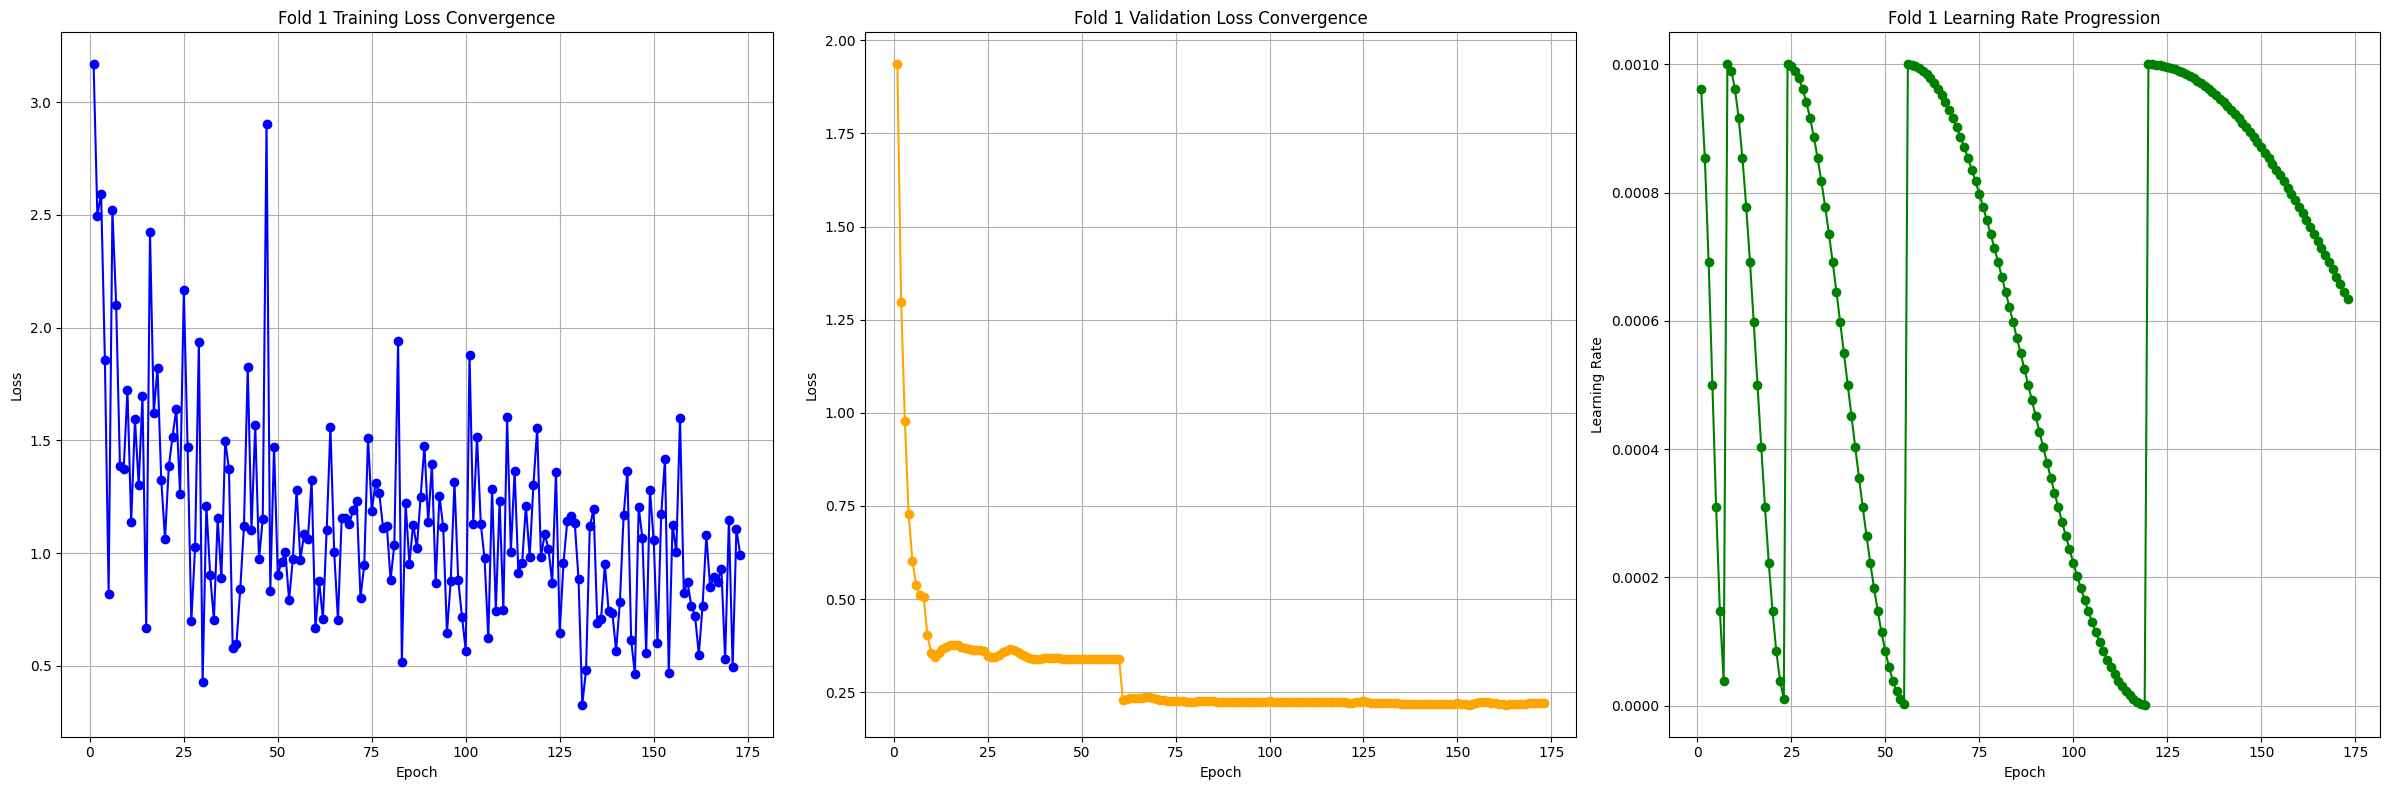

Starting fold 2/3
Early stopping triggered.


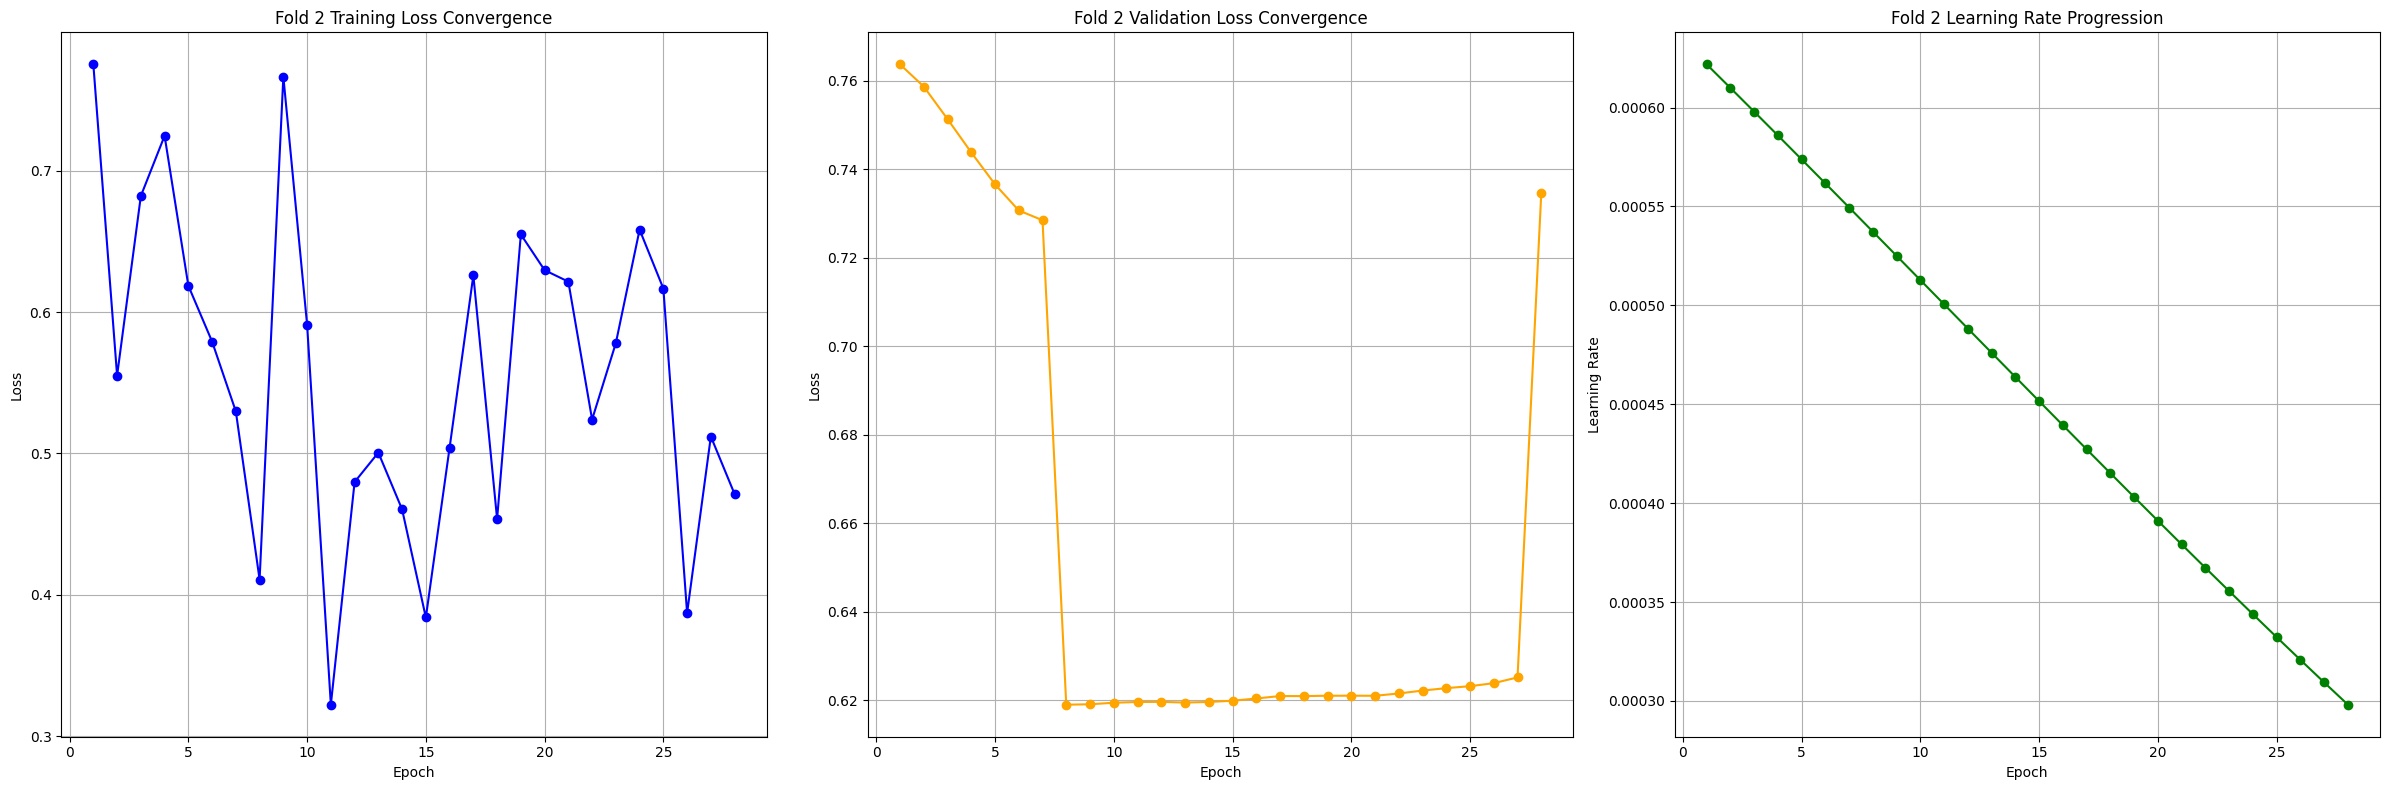

Starting fold 3/3
Early stopping triggered.


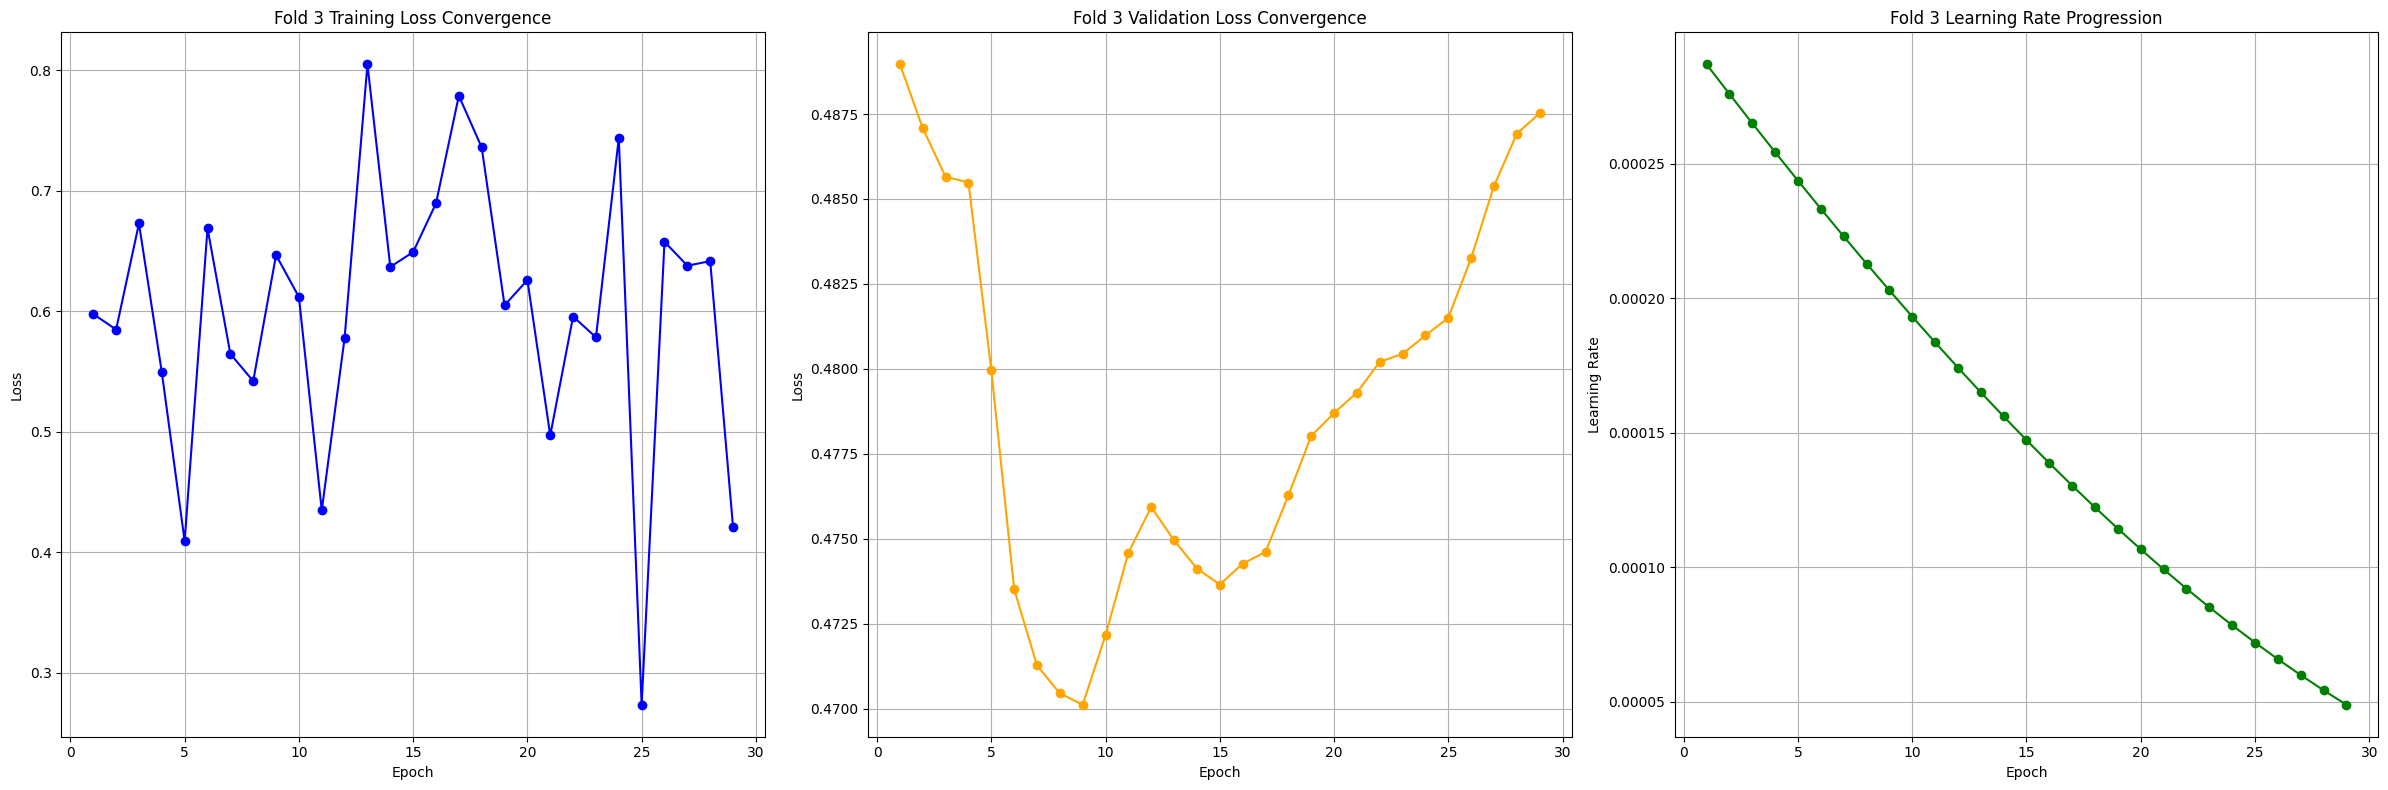

In [16]:
results = trainTSModelCV(
    model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, 
    X=X_train, y=y_train
)

In [17]:
print(f"Validation Losses across folds: {results['folds_val_losses']}")

Validation Losses across folds: [0.21653079851107163, 0.6189745556224476, 0.47011860934170807]


## Question 2: Forecast Comparison

In [18]:
# true values are the last 20% of the data, starting from `train_subset_idx`
true_values = data_["co2"][train_subset_idx:].values
true_values

array([-1.51292 ,  0.731312, -0.658134, -0.934407, -1.452547, -1.371851,
       -1.243663, -0.83264 , -0.046711,  0.205868,  0.009312, -2.960228,
        0.387519, -1.566798])

### ARIMA Forecasts

In [19]:
# perform rolling one-step-ahead forecast 
arima_forecasts = []
# loop for 1-step-ahead forecasts on the last 20% of the data
for i in range(train_subset_idx, len(data_)):
    # get (0, ..., i) data
    train_data_i = data_["co2"][:i]
    # declare and fit the ARIMA(0,0,1) model
    arma_i = sm.tsa.arima.ARIMA(train_data_i, order=(0, 0, 1), trend="c", validate_specification=True)
    arma_fitted_i = arma_i.fit()
    # perform and store forecast
    forecast_i = arma_fitted_i.forecast(steps=1)
    arima_forecasts.append(forecast_i.values[0])
arima_forecasts = np.array(arima_forecasts)

### VAR

In [20]:
# perform rolling one-step-ahead forecast 
var_forecasts = []
# loop for 1-step-ahead forecasts on the last 20% of the data
for i in range(train_subset_idx, len(data_)):
    # get (0, ..., i) data for training
    train_data_i = data_[:i]
    # declare and fit the VAR model with 1 lag
    var_i = sm.tsa.VAR(train_data_i)
    var_fitted_i = var_i.fit(maxlags=1, trend="c")
    # perform and store forecast
    forecast_i = var_fitted_i.forecast(y=train_data_i.values[-var_fitted_i.k_ar:], steps=1)
    var_forecasts.append(forecast_i[0])  # append the one-step-ahead forecast
var_forecasts = np.array(var_forecasts)[:, 0]

### LSTM

In [21]:
# get the best lstm model trained on all folds
lstm = results["best_model"]
# set model to evaluation mode
model.eval()
# perform one-step-ahead forecast 
lstm_forecasts = []
lstm_true_values = []
with torch.no_grad():
    for i in range(X_test.size(0)):
        # get a single sample
        single_X = X_test[i].unsqueeze(0)  # add batch dimension
        single_y = y_test[i]
        # predict
        pred = model(single_X)
        # store results
        lstm_forecasts.append(pred.squeeze(0))  # remove batch dimension
        lstm_true_values.append(single_y)
lstm_forecasts = np.array(lstm_forecasts)
lstm_true_values = np.array(lstm_true_values)

In [22]:
lstm_forecasts_2d = np.zeros((len(lstm_forecasts), 2))
lstm_forecasts_2d[:, 0] = np.squeeze(lstm_forecasts, axis=-1)
lstm_forecasts_unscaled = scaler.inverse_transform(lstm_forecasts_2d)[:, 0]
print("Unscaled LSTM Forecasts:")
print(lstm_forecasts_unscaled)

Unscaled LSTM Forecasts:
[-2.32553387 -1.22020286 -0.89198241 -1.23595479 -1.41359022 -0.88396633
 -0.71645904 -0.76586006 -0.90212382 -0.53955369 -0.92402829 -1.64254182
 -1.16888521 -0.68240951]


### Comparison

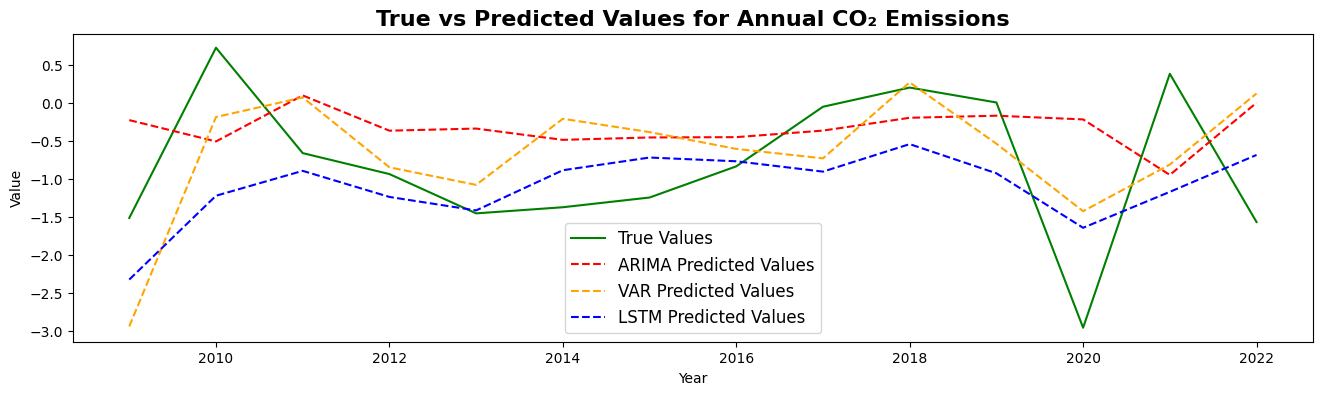

In [23]:
# plot the results
plt.figure(figsize=(16, 4))
plt.plot(data["year"][train_subset_idx:], true_values, label="True Values", color="green")
plt.plot(data["year"][train_subset_idx:], arima_forecasts, label="ARIMA Predicted Values", color="red", linestyle="dashed")
plt.plot(data["year"][train_subset_idx:], var_forecasts, label="VAR Predicted Values", color="orange", linestyle="dashed")
plt.plot(data["year"][train_subset_idx:], lstm_forecasts_unscaled, label="LSTM Predicted Values", color="blue", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Value")
plt.title(f"True vs Predicted Values for Annual CO₂ Emissions", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.show()

In [24]:
def calculateRMSFE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmsfe_arima = calculateRMSFE(true_values, arima_forecasts)
rmsfe_var = calculateRMSFE(true_values, var_forecasts)
rmsfe_lstm = calculateRMSFE(true_values, lstm_forecasts_unscaled)
print(f"ARIMA RMSFE: {rmsfe_arima:.4f}")
print(f"VAR RMSFE: {rmsfe_var:.4f}")
print(f"LSTM RMSFE: {rmsfe_lstm:.4f}")

ARIMA RMSFE: 1.1647
VAR RMSFE: 0.9693
LSTM RMSFE: 0.9349


### Results

LSTM performs the best compared to the ARIMA and VAR models, which is suprising. Even though we have very limited dataset size, we still managed to train a good performing deep learning model. I am particularly impressed by how well the LSTM predicts the direction of the time series, as shown in the plot. Previously, the VAR model was quite effective at forecasting the ups and downs of the time series, but the LSTM has now surpassed it. One of the reasons why LSTM is better is the fact that we used advanced machine learning training techniques, such as time-series cross-validation, a cosine annealing learning rate scheduler with warm restarts, and a custom MSE-direction loss function.